In [152]:
import datetime

import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [153]:
import seaborn as sns
import seaborn_image as isns

In [4]:
comnist_data = np.loadtxt('./../datasets/latin_data.csv', delimiter=",", dtype="float32")
comnist_label = np.loadtxt('./../datasets/latin_label.csv', delimiter=",", dtype="float32")

Displaying letter G
No. of Obs. : 784
Min. Value : 0.0
Max. Value : 1.0
Mean : 0.08124786615371704
Variance : 0.06019669398665428
Skewness : 2.953777313232422


<AxesSubplot:>

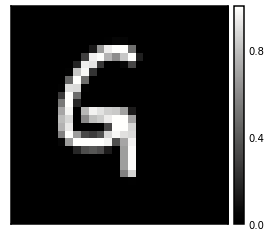

In [5]:
import string

i = np.random.randint(comnist_data.shape[0])
my_letter = np.flip(comnist_data[i].reshape(28, 28), 0)
my_label = string.ascii_uppercase[int(comnist_label[i])]
print(f"Displaying letter {my_label}")
isns.imgplot(my_letter, cmap="gray", describe=True)

In [29]:
import os
from torch.utils.data import Dataset
from torchvision.io import read_image


class СoMNISTDataset(Dataset):
    def __init__(
        self,
        labels_dir,
        data_dir,
        transform=None,
        target_transform=None
    ):
        self.img_labels = pd.read_csv(labels_dir)
        self.img_features = pd.read_csv(data_dir)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = np.asarray(self.img_features.iloc[idx], dtype=np.float32).reshape(28,28)
        label = self.img_labels.iloc[idx, 0]

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [154]:
import torchvision.transforms.functional


training_samples: 10897
validation_samples: 1924

0


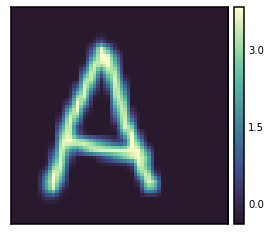

In [155]:
comnnist_dataset = СoMNISTDataset(
    labels_dir='./../datasets/latin_label.csv',
    data_dir='./../datasets/latin_data.csv',
    transform=transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((64,64)),
        transforms.functional.vflip,
        transforms.ToTensor(),
        transforms.Normalize(mean=0.0942,
                             std=0.2352)
    ])
)
# TODO: Refactor to const file etc
TRAINING_PERCENT = 0.85
training_samples = int(len(comnnist_dataset) * TRAINING_PERCENT)
validation_samples = len(comnnist_dataset) - training_samples
print(f'''
training_samples: {training_samples}
validation_samples: {validation_samples}
''')

isns.imshow(comnnist_dataset[100][0].squeeze(0))
print(comnnist_dataset[100][1])

In [ ]:
image = comnnist_dataset[100][0]
plt.imshow(image.permute(1, 2 ,0))

In [ ]:
imgs = torch.stack([img_t for img_t, _ in comnnist_dataset], dim=3)
imgs.shape

In [ ]:
imgs.view(1, -1).mean(dim=1)

In [ ]:
imgs.view(1, -1).std(dim=1)

In [156]:
train_set, val_set = torch.utils.data.random_split(
    comnnist_dataset,
    [training_samples, validation_samples],
    generator=torch.Generator().manual_seed(42))

In [157]:
# TODO: unsure to refactor batch_size to be in separate variable
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=False)

In [ ]:
data_i = iter(train_loader)
images, labels = data_i.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(string.ascii_uppercase[int(labels[idx].item())])

In [ ]:
img = np.squeeze(images[0])

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max() / 2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y], 2) if img[x][y] != 0 else 0
        ax.annotate(str(val), xy=(y, x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y] < thresh else 'black')




In [ ]:
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
class Net(nn.Module):
    def __init__(self, n_out=26):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, n_out)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)

        return out

# initialize the NN
model = Net()
print(model)

In [162]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 26, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [164]:
img, _ = comnnist_dataset[0]
img_batch = img.unsqueeze(0)



In [ ]:
isns.imshow(img.permute(1,2,0))

In [166]:
alexnet = AlexNet()
out = alexnet(img.unsqueeze(0))
out.shape

torch.Size([1, 26])

In [172]:
out = reducedLatinNet(torch.tensor([[0.3,0.4,0.5]]))
out.shape

torch.Size([1, 26])

In [ ]:
out = model(img.unsqueeze(0))
out

In [ ]:
## Specify loss and optimization functions

# specify loss function
loss_fn = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.Adam(alexnet.parameters(), lr=1e-3)


n_epochs = 200

alexnet.train()

for epoch in range(n_epochs):
    loss_train = 0.0
    loss_val = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        outputs = alexnet(images)
        train_loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        loss_train += train_loss.item()

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = alexnet(images)
            val_loss = loss_fn(outputs, labels)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
            loss_val += val_loss.item()

    
    print(f'{datetime.datetime.now()} Epoch {epoch}, Training loss {loss_train / len(train_loader)}' +
          f', Validation loss {loss_val / len(val_loader)}, Accuracy {correct / total}')
    
    if loss_val / len(val_loader) <= 0.3 or loss_train / len(train_loader) <=0.15:
        break

In [ ]:
import seaborn as sns
import pandas as pd

data = pd.DataFrame(dict(epoch=epoch_list, loss=train_loss_list))
sns.set_theme(style="darkgrid")

fig = sns.relplot(
    x='epoch'
    , y='loss'
    , kind='scatter'
    , data=data
)
fig.savefig("output_3_80_relu.png")

In [ ]:
import string
# obtain one batch of test images
loader = torch.utils.data.DataLoader(val_set, batch_size=20, shuffle=True)
dataiter = iter(loader)
images, labels = dataiter.next()

# get sample outputs
output = alexnet(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(
        "{} ({})".format(string.ascii_uppercase[int(preds[idx].item())],string.ascii_uppercase[int(labels[idx].item())]),
        color=("green" if preds[idx] == labels[idx] else "red"))




In [ ]:
# import torch
# torch.cuda.is_available()

In [ ]:
# torch.zeros(1).cuda()


In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()  # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item() * data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(100):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)')

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

## Dimensionality Reduction using Supervised UMAP
Using UMAP implementation from sci-kit learn library

In [15]:
import plotly.express as px
import matplotlib.pyplot as plt

from umap import UMAP

In [16]:
reducer = UMAP(
    n_neighbors=100,
    n_components=3,
    n_epochs=1000,
    min_dist=0.5,
    local_connectivity=10,
    random_state=42
)

In [17]:
X_train_res = 0
X_test_res = 0
batch = 0

reducer_train_loader = torch.utils.data.DataLoader(train_set, batch_size=len(train_set), shuffle=True)
reducer_val_loader = torch.utils.data.DataLoader(val_set, batch_size=len(val_set), shuffle=False)

X_train_res = np.array()
X_test_res = np.array()

for images, labels in reducer_train_loader:
    # TODO: Notate batch size trick
    batch_size = images.shape[0]
    images_a = images.reshape(batch_size,-1).numpy()
    labels_a = labels.numpy()
    X_train_res = reducer.fit_transform(images_a, labels_a)

    break


print(f'''Shape of X_train_res: {X_train_res.shape}''')

Shape of X_train_res: (10897, 3)


In [18]:
def chart(X, y):
    #--------------------------------------------------------------------------#
    # This section is not mandatory as its purpose is to sort the data by label
    # so, we can maintain consistent colors for digits across multiple graphs

    # Concatenate X and y arrays
    arr_concat=np.concatenate((X, y.reshape(y.shape[0],1)), axis=1)
    # Create a Pandas dataframe using the above array
    df=pd.DataFrame(arr_concat, columns=['x', 'y', 'z', 'label'])
    # Convert label data type from float to integer
    df['label'] = df['label'].astype(int)
    # Finally, sort the dataframe by label
    df.sort_values(by='label', axis=0, ascending=True, inplace=True)
    #--------------------------------------------------------------------------#

    # Create a 3D graph
    fig = px.scatter_3d(df, x='x', y='y', z='z', color=df['label'].astype(str), height=900, width=950)

    # Update chart looks
    fig.update_layout(title_text='UMAP',
                      showlegend=True,
                      legend=dict(orientation="h", yanchor="top", y=0, xanchor="center", x=0.5),
                      scene_camera=dict(up=dict(x=0, y=0, z=1),
                                            center=dict(x=0, y=0, z=-0.1),
                                            eye=dict(x=1.5, y=-1.4, z=0.5)),
                                            margin=dict(l=0, r=0, b=0, t=0),
                      scene = dict(xaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             ),
                                   yaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                              ),
                                   zaxis=dict(backgroundcolor='lightgrey',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             )))
    # Update marker size
    fig.update_traces(marker=dict(size=3, line=dict(color='black', width=0.1)))

    fig.show()

In [ ]:
for images, labels in reducer_val_loader:
    batch_size = images.shape[0]
    images_a = images.reshape(batch_size, -1).numpy()
    X_test_res = reducer.transform(images_a)
    chart(X_test_res, labels)

    break


### Artificial Neural Network Model
That can distinct our reduced dataset by UMAP, from 3 input features to 26 classes

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [224]:
class ReducedLatinNet(nn.Module):
    def __init__(self, num_classes: int = 26) -> None:
        super().__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.fc1(torch.tanh(x))
        out = self.fc2(torch.tanh(out))
        out = self.fc3(torch.tanh(out))
        out = self.fc4(torch.tanh(out))
        out = self.fc5(torch.tanh(out))
        return out

reducedLatinNet = ReducedLatinNet()

In [427]:
reducedLatinNet

ReducedLatinNet(
  (fc1): Linear(in_features=3, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=26, bias=True)
)

In [104]:
comnist_data.shape

(12822, 784)

In [105]:
reduced_images_a = np.load('./../datasets/reduced/latin_data.npy')
reduced_images = torch.as_tensor(reduced_images_a)
reduced_images.shape, comnist_label.shape

(torch.Size([12822, 3]), (12822,))

In [135]:
from torch.utils.data import TensorDataset

reducedCoMNISTDataset = TensorDataset(
    reduced_images,
    torch.as_tensor(comnist_label)
    #torch.nn.functional.one_hot(
    #    torch.as_tensor(comnist_label).long(),
    #    num_classes=26
    #)
)

In [186]:
TRAINING_PERCENT = 0.85
training_samples = int(len(reducedCoMNISTDataset) * TRAINING_PERCENT)
validation_samples = len(reducedCoMNISTDataset) - training_samples

reduced_train_set, reduced_val_set = torch.utils.data.random_split(
    reducedCoMNISTDataset,
    [training_samples, validation_samples],
    generator=torch.Generator().manual_seed(42))

In [209]:
reduced_train_loader = torch.utils.data.DataLoader(reduced_train_set, batch_size=64, shuffle=True)
reduced_val_loader = torch.utils.data.DataLoader(reduced_val_set, batch_size=64, shuffle=False)

In [188]:
features, labels = iter(train_loader).next()

features.shape, labels.shape

(torch.Size([256, 1, 64, 64]), torch.Size([256]))

In [189]:
features, labels = iter(reduced_train_loader).next()

features.shape, labels.shape

(torch.Size([1, 3]), torch.Size([1]))

In [161]:
features.unsqueeze(1).shape

torch.Size([256, 1, 3])

In [ ]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total:
        print()

In [291]:
n_epochs = 5000

reducedLatinNet = ReducedLatinNet()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=reducedLatinNet.parameters(), lr=1e-3)

reducedLatinNet.train()

for epoch in range(n_epochs):
    loss_train = 0.0
    loss_val = 0.0
    correct = 0
    total = 0

    for features, labels in reduced_train_loader:
        outputs = reducedLatinNet(features)
        train_loss = loss_fn(
            outputs,
            labels.long()
        )
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        loss_train += train_loss.item()

    with torch.no_grad():
        for features, labels in reduced_val_loader:
            outputs = reducedLatinNet(features)
            val_loss = loss_fn(
                outputs,
                labels.long()
            )
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
            loss_val += val_loss.item()

    if \
        epoch % 500 == 0 \
        or epoch < 10 \
        or epoch > n_epochs - 10:
        print(f'''
        Epoch: {epoch}
        - Time:           {datetime.datetime.now()}
        - Train loss:     {loss_train/len(reduced_train_loader)}
        - Validation loss {loss_val / len(reduced_val_loader)}
        - Accuracy        {correct / total}
        ''')
    elif epoch % 500 != 0\
        and 10 < epoch < n_epochs - 10:
        printProgressBar(
            epoch,
            n_epochs,
            length=50,
            prefix=f'Epoch: {epoch} Accuracy: {round(correct / total, 2)}:',
            suffix=f'N of Epochs: {n_epochs}'
        )

    if round(correct / total, 2) >= 0.85:
        break


        Epoch: 0
        - Time:           2021-11-27 14:48:15.226098
        - Train loss:     3.2503021125904996
        - Validation loss 3.2441007783336024
        - Accuracy        0.06912681912681913
        

        Epoch: 1
        - Time:           2021-11-27 14:48:16.102691
        - Train loss:     3.239471435546875
        - Validation loss 3.2331360463173158
        - Accuracy        0.13201663201663202
        

        Epoch: 2
        - Time:           2021-11-27 14:48:16.944700
        - Train loss:     3.22831840682448
        - Validation loss 3.2219662204865487
        - Accuracy        0.13773388773388773
        

        Epoch: 3
        - Time:           2021-11-27 14:48:17.776821
        - Train loss:     3.2169047015452246
        - Validation loss 3.2103844304238596
        - Accuracy        0.14033264033264034
        

        Epoch: 4
        - Time:           2021-11-27 14:48:18.994121
        - Train loss:     3.2050546874776917
        - Validation lo

In [292]:
from main import VersionFormatter

version = VersionFormatter.by_datetime()
REDUCEDLATINNET_PATH = 'D:/Documents/MAI/Course/models/reducedlatinnet/ReducedLatinNet_{version}'

torch.save(reducedLatinNet, REDUCEDLATINNET_PATH.format(version = version))

In [266]:
import pickle

UMAP_PICKLE_PATH = 'D:/Documents/MAI/Course/models/umap/UMAP_11_26_00_24_51'
with open(UMAP_PICKLE_PATH, 'rb') as pickle_file:
    reducer = pickle.load(pickle_file)

In [416]:
features_reduced, labels = iter(torch.utils.data.DataLoader(reduced_val_set, batch_size=20, shuffle=True)).next()
features_reduced.shape


torch.Size([20, 3])

In [426]:

# get sample outputs
output = reducedLatinNet(features_reduced)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
total = 0
correct = 0
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    print(f'''
Prediction: {string.ascii_uppercase[int(preds[idx].item())]}
Label: {string.ascii_uppercase[int(labels[idx].item())]}
Correct: {preds[idx] == labels[idx]}
    ''')
    total += 1
    correct += 1 if preds[idx] == labels[idx] else 0
    #display(Markdown(f'{string.ascii_uppercase[int(labels[idx].item())]} <span style="color: {"green" if preds[idx] == labels[idx] else "red"}">{string.ascii_uppercase[int(preds[idx].item())]}</span>'))

    # ax.set_title(
    #     "{} ({})".format(string.ascii_uppercase[int(preds[idx].item())],,
    #     color=("green" if preds[idx] == labels[idx] else "red"))

print(f'''

Summary
- Accuracy: {correct/total}
''')


Prediction: Y
Label: Y
Correct: True
    

Prediction: P
Label: P
Correct: True
    

Prediction: P
Label: R
Correct: False
    

Prediction: I
Label: M
Correct: False
    

Prediction: M
Label: M
Correct: True
    

Prediction: E
Label: E
Correct: True
    

Prediction: P
Label: T
Correct: False
    

Prediction: L
Label: L
Correct: True
    

Prediction: P
Label: P
Correct: True
    

Prediction: J
Label: J
Correct: True
    

Prediction: B
Label: C
Correct: False
    

Prediction: B
Label: B
Correct: True
    

Prediction: Z
Label: X
Correct: False
    

Prediction: W
Label: W
Correct: True
    

Prediction: C
Label: D
Correct: False
    

Prediction: O
Label: O
Correct: True
    

Prediction: Z
Label: U
Correct: False
    

Prediction: C
Label: C
Correct: True
    

Prediction: F
Label: F
Correct: True
    

Prediction: W
Label: W
Correct: True
    


Summary
- Accuracy: 0.65



<Figure size 1800x288 with 0 Axes>